In [11]:
import xarray as xr
import numpy as np
from scipy.io import loadmat
from scipy import interpolate
from scipy import signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import seastar as ss
import seastar.oscar
import seastar.retrieval
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import re
import warnings
import os
from shapely.geometry import Point

In [2]:
# Data load and pre-processing
#oscar_path = "D:\\data\\SEASTAR\\SEASTARex\\Data\\Metasensing\\OSCAR\\Brest_Sample_Oct_13_2022_precompute\\"
#oscar_path = "D:\\data\\SEASTAR\\SEASTARex\\Data\\Metasensing\\OSCAR\\May22_full_precompute\\"
oscar_path = "D:\\data\\SEASTAR\\SEASTARex\\Data\\Metasensing\\OSCAR\\Brest_Sample_Dec_8\\"
#oscar_path = "D:\\data\\oscar\\Brest_Sample_Oct_13_2022\\"
file_time_triplets = ss.utils.tools.find_file_triplets(oscar_path)

print('OSCAR L1 processing')
print('-------------------')
print('File path :', oscar_path)
print('-------------------')
for i in range(len(file_time_triplets)):
    print('File index :', i, ',', 'Aquisition time :', file_time_triplets[i][0], ',', 'File list indices :', file_time_triplets[i][1])
file_index = 0 #Process single file from list below
ds = ss.utils.readers.load_OSCAR_data(oscar_path, file_time_triplets[file_index][1])
#antenna_ident = ss.utils.tools.antenna_idents(ds)
antenna_ident = ss.utils.tools.identify_antenna_location_from_filename(oscar_path, file_time_triplets[file_index][1])
ds = ss.oscar.level1.fill_missing_variables(ds, antenna_ident)
print('Processing file index',file_index)

OSCAR L1 processing
-------------------
File path : D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\Brest_Sample_Dec_8\
-------------------
File index : 0 , Aquisition time : 20220517T093239 , File list indices : [0, 1, 2]
File index : 1 , Aquisition time : 20220517T101737 , File list indices : [3, 4, 5]
Processing file index 0


In [4]:
# L1 processing
window = 7
for i in list(ds.keys()):
    ds[i] = ss.oscar.level1.check_antenna_polarization(ds[i])
    ds[i] = ss.oscar.level1.compute_multilooking_Master_Slave(ds[i], window)
    ds[i]['Baseline'] = ss.oscar.level1.compute_antenna_baseline(0.2)
    ds[i] = ss.oscar.level1.compute_antenna_azimuth_direction(ds[i], antenna=antenna_ident[list(ds.keys()).index(i)])
    ds[i] = ss.oscar.level1.compute_time_lag_Master_Slave(ds[i], options='from_SAR_time')
    ds[i] = ss.oscar.level1.compute_radial_surface_velocity(ds[i])
#Build L1 dataset
dsl1 = ss.oscar.level1.merge_beams(ds, antenna_ident)
# Generating geophysical data fields for GMF doppler computation
u10 = 10 # wind speed
wind_direction = 150 # wind direction
aux = ss.oscar.level1.init_auxiliary(dsl1,u10,wind_direction)
# Compute RSC
dsl1 = compute_radial_surface_current(dsl1, aux, gmf='mouche12')
#dsl1 = ss.oscar.level1.compute_radial_surface_current(dsl1, aux, gmf='mouche12')
#L2 Processing
# Initialise l2 dataset
dsl2=ss.oscar.level1.init_level2(dsl1)
# Compute current magnitude and direction
dsl2=seastar.retrieval.level2.compute_current_magnitude_and_direction(dsl1, dsl2)
# Compute current vectors
dsl2['CurrentVectorUComponent'], dsl2['CurrentVectorVComponent'] =\
ss.utils.tools.currentVelDir2UV(dsl2['CurrentMagnitude'], dsl2['CurrentDirection'])


In [5]:
# Load Auxiliary data

xband_file="D:\data\SEASTAR\SEASTARex\Data\Hereon\Xband_radar_17th_may.mat"
ds_xband = ss.retrieval.auxiliary.colocate_xband_marine_radar_data(xband_file, dsl2)
ds_xband['CurrentMagnitude'], ds_xband['CurrentDirection'] =ss.retrieval.auxiliary.\
compute_Xband_current_magnitude_and_direction(ds_xband)

folder = 'unrestricted\\'
aux_data_folder = "D:\\data\\SEASTAR\\SEASTARex\\Data\\Iframer\\"
list22 = {}
list22['F1'] = 'MARC_F1-MARS3D-MANGAE2500_SEASTAREX_20220517.nc'
list22['L1'] = 'MARC_L1-MARS2D-FINIS250_SEASTAREX_20220517.nc'
list22['W3'] = 'WW3_NORGAS-UG_SEASTAREX_20220517.nc'

F1 = xr.open_dataset(aux_data_folder + folder + list22['F1'])
L1 = xr.open_dataset(aux_data_folder + folder + list22['L1'])
W3 = xr.open_dataset(aux_data_folder + folder + list22['W3'])


cvel, cdir = ss.utils.tools.currentUV2VelDir(L1.U.data, L1.V.data)
L1['CurrentMagnitude'] = (('time','nj','ni'), cvel)
L1['CurrentDirection'] = (('time','nj','ni'), cdir)




In [6]:
L1_CurrentMagnitude_colocated = ss.retrieval.auxiliary.colocate_variable_lat_lon(L1.CurrentMagnitude.isel(time=4),
                                                                                 L1.latitude,
                                                                                 L1.longitude,
                                                                                 dsl2
                                                                                )

In [ ]:
ax3 = dsl1.SquintImage.sel(Antenna='Fore').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )
ax3 = dsl1.SquintImage.sel(Antenna='Aft').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )
ax3 = dsl1.AntennaAzimuthImage.sel(Antenna='Fore').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )
ax3 = dsl1.AntennaAzimuthImage.sel(Antenna='Aft').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )

In [ ]:

fig = plt.figure(figsize=(10, 10))
plt.hexbin(
    x=L1_CurrentMagnitude_colocated\
    .values\
    .flatten(), 
    y=dsl2\
    .CurrentMagnitude\
    .values\
    .flatten(),
    gridsize=100,
    cmap='gist_yarg',
)

plt.xlim([0,3])
plt.ylim([0,3])
plt.plot([0,3],[0,3],'k')
#plt.axis('equal')
#plt.title('Derived surface currents')
plt.xlabel('MARS2D surface current magnitude (m/s)')
plt.ylabel('OSCAR surface current magnitude (m/s)')
#ax.set(xticklabels=[])

In [ ]:
# Plot current magnitude with u,v vectors overlain, geographic coordinates
plot_pixel_size = 200 #pixel size in metres
sar_pixel_size = 8
c_factor = int(plot_pixel_size / sar_pixel_size)
#c_factor = 1 # Coarsening factor
q_factor = 30 # Quiver plot scaling factor


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
dsl2\
.coarsen(GroundRange=c_factor,boundary='trim').mean()\
.coarsen(CrossRange=c_factor,boundary='trim').mean()\
.CurrentMagnitude.plot(
    y='latitude',
    x='longitude',
    robust=True, 
    cmap='coolwarm',
    vmin=0, vmax=3,
    transform=ccrs.PlateCarree()
)
dsl2\
.coarsen(GroundRange=q_factor,boundary='trim').mean()\
.coarsen(CrossRange=q_factor,boundary='trim').mean()\
.plot.quiver(
    x='longitude',
    y='latitude',
    u='CurrentVectorUComponent',
    v='CurrentVectorVComponent',
    scale=30,
    angles='xy',
    robust=True,
    transform=ccrs.PlateCarree()
)
#plt.plot((5.13305, 48.4166), marker="^", color='r', markersize=2)
#plt.show()
plt.title(dsl1.attrs['History'])
gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.2, -5.0, 48.37, 48.5], crs=ccrs.PlateCarree())
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore", category=Warning)
ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'))

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
L1.CurrentMagnitude.isel(time=4)\
.plot(
    y='latitude',
    x='longitude',
    robust=True, 
    cmap='coolwarm',
    vmin=0, vmax=3,
    transform=ccrs.PlateCarree()
)

#L1sel=L1.isel(time=4)
#L1sel\
#.plot.quiver(
#    x='longitude',
#    y='latitude',
#    u='U',
#    v='V',
#    scale=30,
#    angles='xy',
#    robust=True,
#    transform=ccrs.PlateCarree()
#)

gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.2, -5.0, 48.37, 48.5], crs=ccrs.PlateCarree())
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore", category=Warning)
ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'))

In [10]:
from shapely.geometry import Point

In [61]:
def compute_land_mask_from_GSHHS(ds, erosion=False, boundary=None,
                                 erode_scale=3, coastline_selection=0):
    

    if 'longitude' not in ds.coords or 'latitude' not in ds.coords:
        raise Exception('longitude and latitude missing from input dataset')
    if not boundary:
        boundary = [np.min(ds.longitude.data),
                    np.max(ds.longitude.data),
                    np.min(ds.latitude.data),
                    np.max(ds.latitude.data)]

    if erosion:
        erode_scale = int(np.round(erode_scale))
        erode_structure = np.full((erode_scale, erode_scale), True)
    coast_polygons = dict()
    coast = cfeature.GSHHSFeature(scale='full')\
        .intersecting_geometries(boundary)

    for k, polygon in enumerate(coast):
        coast_polygons[k] = polygon
    if type(coastline_selection) is int:
        coastline_selection = [coastline_selection]
    if np.max(coastline_selection) > k:
        raise Exception('Selected coastline(s)' ,
                        coastline_selection,
                        ' different to coastlines identified within boundary ',
                        list(coast_polygons.keys()),
                        '. Please try a different coastline_selection (default=0)'
                       )
    
    coast_polygons = {key: coast_polygons[key]
                          for key in coastline_selection}
    m, n = ds.longitude.shape
    mask = np.full((m, n), False)
    for i in range(m):
        for j in range(n):
            for k in coast_polygons.keys():
                mask[i, j] = mask[i, j] or\
                    Point(ds.longitude.data[i, j], ds.latitude.data[i, j])\
                    .within(coast_polygons[k])
    if erosion:
        mask = erode(mask, structure=erode_structure)
    mask = xr.DataArray(data=mask,
                        coords=ds.latitude.coords,
                        dims=ds.latitude.dims)
    

    return mask, coast_polygons

In [62]:
mask, coast_polygons = compute_land_mask_from_GSHHS(dsl1, coastline_selection=[0])

In [32]:
coastline_selection=[100]
coast_polygons={'0':1, '1':2}
if len(coastline_selection) > len(coast_polygons):
    print('Number of coastlines in coastline_selection (',
          len(coastline_selection),
          ') is greater than the number of coastlines intersecting with the given boundary (',
          len(coast_polygons)
         )
if np.max(coastline_selection) > k:
    print()


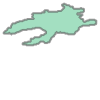

In [65]:
coast_polygons[0]

In [ ]:
# Compute Ushant mask
from shapely.geometry import Point
coast = cfeature.GSHHSFeature(scale='full').intersecting_geometries([-5.2, -5.0, 48.37, 48.5])
coast_polygon = next(coast)
m, n = dsl2.longitude.shape
mask = np.full((m,n), True)
for i in range(m):
    for j in range(n):
        mask[i,j]= Point(dsl2.longitude.data[i,j],dsl2.latitude.data[i,j]).within(coast_polygon)
mask=xr.DataArray(data=mask,
                 coords=dsl2.coords,
                 dims=dsl2.dims)

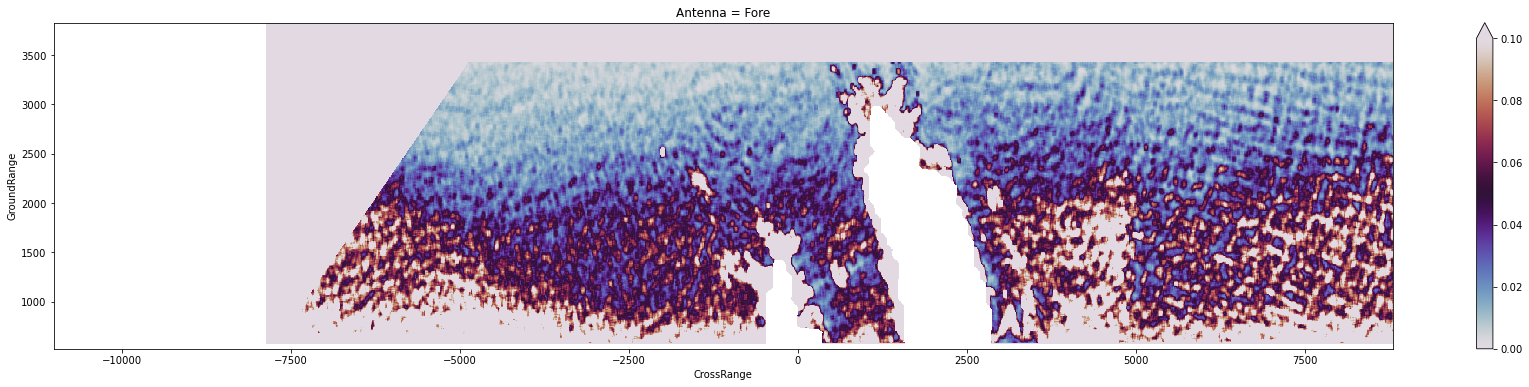

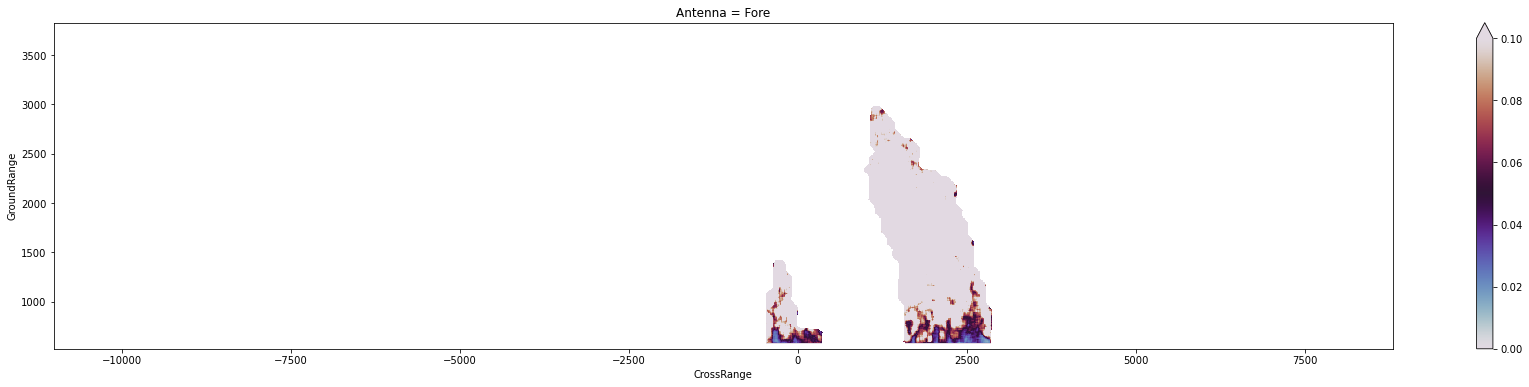

In [63]:
#A = dsl1.Coherence.sel(Antenna='Fore')

ax3 = xr.where(~mask, dsl1.Intensity.sel(Antenna='Fore'), np.NaN).plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                        vmin=0, vmax=0.1,
                        cmap='twilight',

                      )
ax3 = xr.where(mask, dsl1.Intensity.sel(Antenna='Fore'), np.NaN).plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                        cmap='twilight',
                        vmin=0, vmax=0.1,

                      )
#print(np.mean(xr.where(mask, dsl1.RadialSurfaceVelocity.sel(Antenna='Fore'), np.NaN)))
#print(np.mean(xr.where(mask, dsl1.RadialSurfaceVelocity.sel(Antenna='Aft'), np.NaN)))

In [ ]:
dsl1.isel(CrossRange=100).plot.scatter(x='GroundRange',y='IncidenceAngleImage',hue='Antenna') 

In [ ]:
dsl1.Coherence.median(dim='CrossRange').plot(hue='Antenna')

#dsf.SigmaImageAmplitude.median(dim='GroundRange').plot(label='Fore')
#dsa.SigmaImageAmplitude.median(dim='GroundRange').plot(label='Aft')

In [ ]:
dsl1.IncidenceAngleImage.median(dim='CrossRange').plot(hue='Antenna')
plt.title(dsl1.attrs['History'])

In [ ]:
dsl1.attrs['History']

In [ ]:
dsl1.IncidenceAngleImage.median(dim='CrossRange').plot(hue='Antenna')
plt.title(dsl1.attrs['History'])

In [ ]:
dsl1.isel(CrossRange=1000).IncidenceAngleImage.plot(hue='Antenna')

In [ ]:
ax3 = dsl1.IncidenceAngleImage.sel(Antenna='Fore').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )
ax3 = dsl1.IncidenceAngleImage.sel(Antenna='Aft').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )
ax3 = dsl1.Coherence.sel(Antenna='Fore').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='twilight',

                      )
ax3 = dsl1.Coherence.sel(Antenna='Aft').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='twilight',

                      )
ax3 = dsl1.Interferogram.sel(Antenna='Fore').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='twilight',

                      )
ax3 = dsl1.Interferogram.sel(Antenna='Aft').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='twilight',

                      )

In [ ]:
ax3 = dsl1.RadialSurfaceCurrent.sel(Antenna='Fore').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )
ax3 = dsl1.RadialSurfaceCurrent.sel(Antenna='Aft').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )

In [ ]:
dsl2.latitude

In [1]:
def compute_radial_surface_current(level1, aux, gmf='mouche12'):
    """
    Compute radial surface current (RSC).

    Compute radial surface current (RSC) from radial surface velocity (RSV)
    and the wind artifact surface velocity (WASV) from:
        RSC = RSV - WASV

    Parameters
    ----------
    level1 : xarray.Dataset
        L1 dataset
    aux : xarray.Dataset
        Dataset containing geophysical wind data
    gmf : str, optional
        Choice of geophysical model function to compute the WASV.
        The default is 'mouche12'.

    Returns
    -------
    level2 : xarray.Dataset
        L2 dataset

    """
    dswasv_f = seastar.gmfs.doppler.compute_wasv(level1.sel(Antenna='Fore'),
                                                 aux,
                                                 gmf)
    dswasv_a = seastar.gmfs.doppler.compute_wasv(level1.sel(Antenna='Aft'),
                                                 aux,
                                                 gmf)
    dswasv_m = seastar.gmfs.doppler.compute_wasv(level1.sel(Antenna='Mid'),
                                                 aux,
                                                 gmf)

    level1['RadialSurfaceCurrent'] = xr.concat(
        [level1.RadialSurfaceVelocity.sel(Antenna='Fore') - dswasv_f.WASV,
         -level1.RadialSurfaceVelocity.sel(Antenna='Aft') - dswasv_a.WASV,
         level1.RadialSurfaceVelocity.sel(Antenna='Mid') - dswasv_m.WASV],
        'Antenna', join='outer')
    level1['RadialSurfaceCurrent'] = level1.RadialSurfaceCurrent.assign_coords(

    Antenna=('Antenna', list(level1.Antenna.data)))

    level1.RadialSurfaceCurrent.attrs['long_name'] =\
        'Radial Surface Current (RSC) along antenna beam direction, corrected'\
        'for Wind Artifact Surface Velocity (WASV)'
    level1.RadialSurfaceCurrent.attrs['units'] = '[m/s]'

    return level1

In [ ]:
def compute_radial_surface_current(level1, aux, gmf='mouche12'):
    """
    Compute radial surface current (RSC).

    Compute radial surface current (RSC) from radial surface velocity (RSV)
    and the wind artifact surface velocity (WASV) from:
        RSC = RSV - WASV

    Parameters
    ----------
    level1 : xarray.Dataset
        L1 dataset
    aux : xarray.Dataset
        Dataset containing geophysical wind data
    gmf : str, optional
        Choice of geophysical model function to compute the WASV.
        The default is 'mouche12'.

    Returns
    -------
    level2 : xarray.Dataset
        L2 dataset

    """
    dswasv = seastar.gmfs.doppler.compute_wasv(level1,
                                               aux,
                                               gmf
                                               )
    rsv_list = [level1.RadialSurfaceVelocity.sel(Antenna=a)
                - dswasv.sel(Antenna=a)
                for a in list(level1.Antenna.data)
                ]

    level1['RadialSurfaceCurrent'] = xr.concat(rsv_list,
                                               'Antenna',
                                               join='outer')
    level1['RadialSurfaceCurrent'] = level1.RadialSurfaceCurrent\
        .assign_coords(Antenna=('Antenna',
                                list(level1.Antenna.data)
                                )
                       )
    level1.RadialSurfaceCurrent.attrs['long_name'] =\
        'Radial Surface Current (RSC) along antenna beam direction, corrected'\
        'for Wind Artifact Surface Velocity (WASV)'
    level1.RadialSurfaceCurrent.attrs['units'] = '[m/s]'

    return level1

In [3]:
def compute_radial_surface_current(level1, aux, gmf='mouche12'):
    """
    Compute radial surface current (RSC).

    Compute radial surface current (RSC) from radial surface velocity (RSV)
    and the wind artifact surface velocity (WASV) from:
        RSC = RSV - WASV

    Parameters
    ----------
    level1 : xarray.Dataset
        L1 dataset
    aux : xarray.Dataset
        Dataset containing geophysical wind data
    gmf : str, optional
        Choice of geophysical model function to compute the WASV.
        The default is 'mouche12'.

    Returns
    -------
    level2 : xarray.Dataset
        L2 dataset

    """
    dswasv = seastar.gmfs.doppler.compute_wasv(level1,
                                               aux,
                                               gmf
                                               )
    rsv_list = [level1.RadialSurfaceVelocity.sel(Antenna=a)
                - dswasv.sel(Antenna=a)
                for a in list(level1.Antenna.data)
                ]
    rsv_list[list(level1.Antenna.data).index('Aft')] = \
    -level1.RadialSurfaceVelocity.sel(Antenna='Aft') - dswasv.sel(Antenna='Aft')
    level1['RadialSurfaceCurrent'] = xr.concat(rsv_list,
                                               'Antenna',
                                               join='outer')
    level1['RadialSurfaceCurrent'] = level1.RadialSurfaceCurrent\
        .assign_coords(Antenna=('Antenna',
                                list(level1.Antenna.data)
                                )
                       )
    level1.RadialSurfaceCurrent.attrs['long_name'] =\
        'Radial Surface Current (RSC) along antenna beam direction, corrected'\
        'for Wind Artifact Surface Velocity (WASV)'
    level1.RadialSurfaceCurrent.attrs['units'] = '[m/s]'

    return level1

In [ ]:
list(dsl1.Antenna.data).index('Aft')

In [ ]:
list(dsl1.Antenna.data)

In [ ]:
rsv_list = [dsl1.RadialSurfaceVelocity.sel(Antenna=a)
                for a in list(dsl1.Antenna.data)
                ]
rsv_list[list(dsl1.Antenna.data).index('Aft')] = -dsl1.RadialSurfaceVelocity.sel(Antenna='Aft') - dswasv.sel(Antenna=Aft)

In [ ]:
plt.plot(5.13305, 48.4166, marker="^", color='r', markersize=20)